Loading 5 combinations...
  [1/5] zen=89.9° az=270° h=5000m x=-1m z=0m
91.159904 1.284661


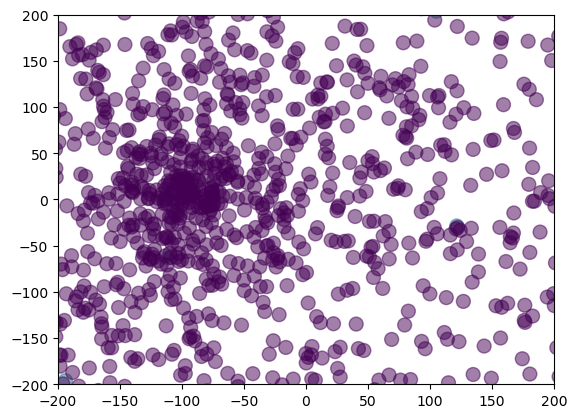

70.8741 31.181871


  [2/5] zen=89.9° az=270° h=5000m x=-0.5m z=0m
91.159904 1.284661


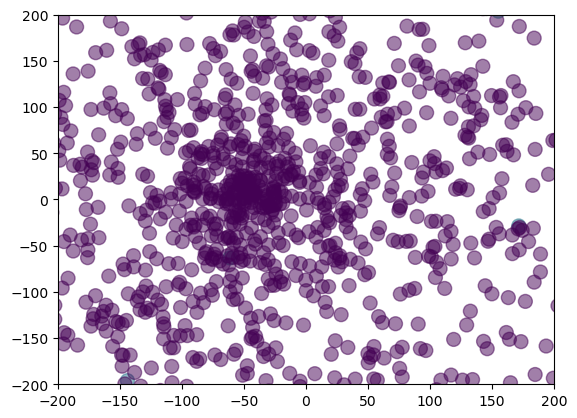

61.394764 30.784363
  [3/5] zen=89.9° az=270° h=5000m x=0m z=0m
91.159904 1.284661


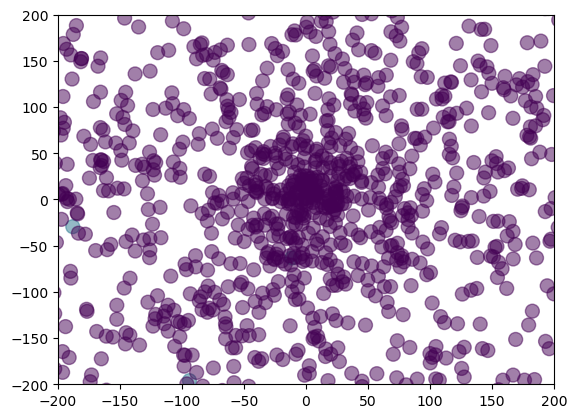

114.9258 25.353552
  [4/5] zen=89.9° az=270° h=5000m x=0.5m z=0m
91.159904 1.284661


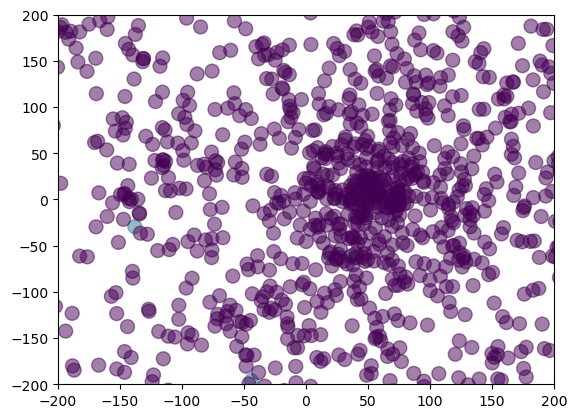

63.452938 33.93427
  [5/5] zen=89.9° az=270° h=5000m x=1m z=0m
91.159904 1.284661


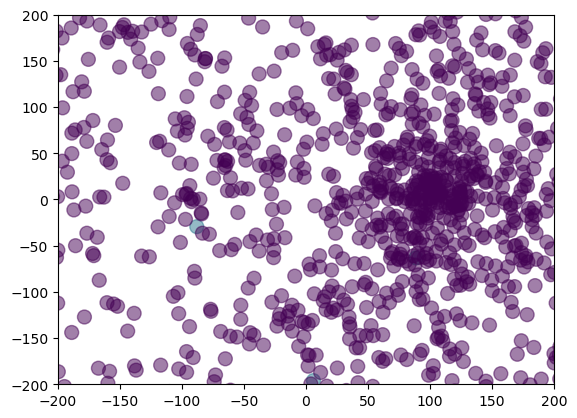

63.723724 31.949677

5 valid combinations loaded. Building Plotly figure...

Saved interactive plot to 'slider_pid13_E1e4_R5_s5.html'


In [95]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u1520754/Muon_Trinity/analysis/')
from ReadTrinity import read_cherenkov_hits, plot_GROPT, plot_CARE
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
# ── Read functions (unchanged) ────────────────────────────────────────────────
def read_specific_cherenkov_hits(pid, E_mag, zen, az, h, x, y, z, r, seed):
    input_file = f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid{pid}_E1e{E_mag}_R{r}/Tilt_pdg{pid}_E1e{E_mag}_zen{zen}_az{az}_h{h}_x{x}_y{y}_z{z}_r{r}_s{seed}/CORSIKA8/cherenkov_hits.dat"
    X, Y, T, cos_X, cos_Y, wavelength, zem, Theta_z, Phi, Slant, Weight = read_cherenkov_hits(input_file, plot=False)
    index = np.where(T==T.min())[0][0]
    phi = np.arccos(cos_X) * 180 / np.pi
    cos_Z = np.sqrt(1- cos_X**2 - cos_Y**2)
    theta = np.arccos(cos_Z) * 180 / np.pi
    print(np.median(phi[index]), np.median(theta[index]))
    plt.scatter(X,Y, c=Slant, s=100, alpha=0.5, cmap="viridis")
    plt.xlim(-200, 200)
    plt.ylim(-200,200)
    plt.show()
    return X, Y, T, cos_X, cos_Y, wavelength, zem, Theta_z, Phi, Slant, Weight

def read_specific_GROPT(pid, E_mag, zen, az, h, x, y, z, r, seed):
    input_file = f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid{pid}_E1e{E_mag}_R{r}/Tilt_pdg{pid}_E1e{E_mag}_zen{zen}_az{az}_h{h}_x{x}_y{y}_z{z}_r{r}_s{seed}/GROPT/cherenkov_hits.root"
    cosx, cosy, photonX_np, photonY_np, T = plot_GROPT(input_file, plot=False)
    index = np.where(T==T.min())[0][0]
    phi = np.arccos(cosx) * 180 / np.pi
    cos_Z = np.sqrt(1- cosx**2 - cosy**2)
    theta = np.arccos(cos_Z) * 180 / np.pi
    print(np.median(phi[index]), np.median(theta[index]))
    return cosx, cosy, photonX_np, photonY_np, T

def read_specific_CARE(pid, E_mag, zen, az, h, x, y, z, r, seed):
    input_file = f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid{pid}_E1e{E_mag}_R{r}/Tilt_pdg{pid}_E1e{E_mag}_zen{zen}_az{az}_h{h}_x{x}_y{y}_z{z}_r{r}_s{seed}/CARE/cherenkov_hits.root"
    camera_matrix, time_ns, total_pe, max_pe, arrays, pixel_config, min_x, max_x, min_y, max_y, pixel_pitch = plot_CARE(input_file, plot=False)
    return camera_matrix, time_ns, total_pe, max_pe, arrays, pixel_config, min_x, max_x, min_y, max_y, pixel_pitch

def get_peak_camera_image(arrays, pixel_config, min_x, min_y, pixel_pitch):
    dc_to_pe = 24.1
    baseline_dc = 500
    all_traces_pe = {}
    for pix_id in range(256):
        trace_name = f"vFADCTraces{pix_id}"
        if trace_name in arrays:
            trace_dc = arrays[trace_name][0]
            trace_pe = np.clip((trace_dc - baseline_dc) / dc_to_pe, 0, None)
            all_traces_pe[pix_id] = trace_pe
    if len(all_traces_pe) == 0:
        return np.zeros((16, 16)), 0
    n_samples = len(list(all_traces_pe.values())[0])
    total_pe_per_step = np.zeros(n_samples)
    for pix_id, trace in all_traces_pe.items():
        total_pe_per_step += trace
    peak_time_step = np.argmax(total_pe_per_step)
    peak_grid = np.zeros((16, 16))
    for pix_id in range(256):
        if pix_id in all_traces_pe:
            x_pos = pixel_config[pix_id][1]
            y_pos = pixel_config[pix_id][2]
            col = int((x_pos - min_x) / pixel_pitch)
            row = int((y_pos - min_y) / pixel_pitch)
            peak_grid[row, col] = all_traces_pe[pix_id][peak_time_step]
    peak_time_ns = peak_time_step * 10 - 170
    return peak_grid, peak_time_ns

# ── Helper: 2D histogram as a matrix ─────────────────────────────────────────
def hist2d_matrix(x_data, y_data, bins, x_range, y_range, weights=None):
    H, xedges, yedges = np.histogram2d(
        x_data, y_data, bins=bins, range=[x_range, y_range], weights=weights
    )
    return np.flip(H.T, axis=0), xedges, yedges  # transpose so row=y, col=x

def to_scalar(val):
    """Convert a numpy array or scalar to a Python float."""
    if isinstance(val, np.ndarray):
        if val.size == 1:
            return float(val.item())
        else:
            return float(val[0])  # or np.sum(val), depending on intent
    return float(val)

# ── Parameters ────────────────────────────────────────────────────────────────
particle_id      = 13
energy_magnitude = 4
zenith_angle     = [89.9] #89.9, 89, 88, 87
azimuthal_angle  = [270] #268, 269, 270, 271, 272
height           = [5000]
radius           = 5
random_seed      = 5
x                = [-1, -0.5, 0, 0.5, 1] #-5,-2,-1,-0.7, -0.5, -0.2, 0, 0.2, 0.5,0.7, 1, 2, 5
y                = 0
z                = [0] #-5,-2,-1,-0.7, -0.5, -0.2, 0, 0.2, 0.5,0.7, 1, 2, 5

# ── Build all combinations and pre-load data ─────────────────────────────────
combos = []
for az in azimuthal_angle:
    for zen in zenith_angle:
        for h in height:
            for x_i in x:
                for z_i in z:
                    combos.append((az, zen, h, x_i, z_i))

print(f"Loading {len(combos)} combinations...")

# Storage for each combo: (label, corsika_H, corsika_xe, corsika_ye,
#                           gropt_H, gropt_xe, gropt_ye,
#                           care_grid, care_extent, peak_time_ns, max_pe, total_pe)
data_store = []

for idx, (az, zen, h, x_i, z_i) in enumerate(combos):
    label = f"zen={zen}° az={az}° h={h}m x={x_i}m z={z_i}m"
    print(f"  [{idx+1}/{len(combos)}] {label}")

    try:
        # CORSIKA8
        X_c, Y_c, T_c, *_ , Weight_c = read_specific_cherenkov_hits(
            pid=particle_id, E_mag=energy_magnitude, zen=zen, az=az,
            h=h, x=x_i, y=y, z=z_i, r=radius, seed=random_seed)
        H1, xe1, ye1 = hist2d_matrix(
            X_c / 1e2, Y_c / 1e2, bins=10,
            x_range=[-2, 2], y_range=[-2, 2],
            weights=np.ones(len(X_c)) * 5)
        H1 = np.flip(H1, axis=0) 
        # GROPT
        cosx, cosy, photonX_np, photonY_np, T_g = read_specific_GROPT(
            pid=particle_id, E_mag=energy_magnitude, zen=zen, az=az,
            h=h, x=x_i, y=y, z=z_i, r=radius, seed=random_seed)
        H2, xe2, ye2 = hist2d_matrix(
            photonY_np, photonX_np, bins=16,
            x_range=[-50, 50], y_range=[-50, 50])
        H2 = np.flip(H2, axis=1)
        # CARE
        camera_matrix, time_ns, total_pe, max_pe, arrays, pixel_config, \
            min_x_c, max_x_c, min_y_c, max_y_c, pixel_pitch = read_specific_CARE(
            pid=particle_id, E_mag=energy_magnitude, zen=zen, az=az,
            h=h, x=x_i, y=y, z=z_i, r=radius, seed=random_seed)
        peak_grid, peak_time_ns = get_peak_camera_image(
            arrays, pixel_config, min_x_c, min_y_c, pixel_pitch)

        care_extent = (min_x_c, max_x_c, min_y_c, max_y_c)
        data_store.append({
            "label": label,
            "az": az, "zen": zen, "h": h, "x": x_i, "z": z_i,
            "H1": H1, "xe1": xe1, "ye1": ye1,
            "H2": H2, "xe2": xe2, "ye2": ye2,
            "care_grid": peak_grid,
            "care_extent": care_extent,
            "peak_time_ns": to_scalar(peak_time_ns),
            "max_pe": to_scalar(max_pe),
            "total_pe": to_scalar(total_pe),
        })
    except Exception as e:
        print(f"    ⚠ SKIPPED: {e}")
        data_store.append(None)

# Filter out failed combos
valid = [(i, d) for i, d in enumerate(data_store) if d is not None]
if len(valid) == 0:
    raise RuntimeError("No valid data loaded!")
print(f"\n{len(valid)} valid combinations loaded. Building Plotly figure...")

# ── Build Plotly figure with slider ───────────────────────────────────────────
n = len(valid)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=["CORSIKA8 Cherenkov Hits", "GROPT Photon Positions", "CARE Camera (Peak)"],
    horizontal_spacing=0.08,
)

# We add 3 heatmap traces per combo (all invisible except first)
for trace_idx, (_, d) in enumerate(valid):
    visible = (trace_idx == 0)

    # Panel 1: CORSIKA8
    xe1_c = 0.5 * (d["xe1"][:-1] + d["xe1"][1:])
    ye1_c = 0.5 * (d["ye1"][:-1] + d["ye1"][1:])
    fig.add_trace(
        go.Heatmap(
            z=d["H1"], x=xe1_c, y=ye1_c,
            colorscale="Viridis", colorbar=dict(title="Counts", x=0.28, len=0.9),
            visible=visible, name="CORSIKA8",
        ),
        row=1, col=1,
    )

    # Panel 2: GROPT
    xe2_c = 0.5 * (d["xe2"][:-1] + d["xe2"][1:])
    ye2_c = 0.5 * (d["ye2"][:-1] + d["ye2"][1:])
    fig.add_trace(
        go.Heatmap(
            z=d["H2"], x=xe2_c, y=ye2_c,
            colorscale="Viridis", colorbar=dict(title="Counts", x=0.63, len=0.9),
            visible=visible, name="GROPT",
        ),
        row=1, col=2,
    )

    # Panel 3: CARE
    ext = d["care_extent"]
    care_x = np.linspace(ext[0], ext[1], d["care_grid"].shape[1])
    care_y = np.linspace(ext[2], ext[3], d["care_grid"].shape[0])
    fig.add_trace(
        go.Heatmap(
            z=np.flip(np.flip(d["care_grid"].T, axis=0), axis=1), x=care_x, y=care_y,
            colorscale="Viridis", colorbar=dict(title="PE", x=1.0, len=0.9),
            visible=visible, name="CARE",
        ),
        row=1, col=3,
    )

# ── Slider steps ──────────────────────────────────────────────────────────────
steps = []
for step_idx, (_, d) in enumerate(valid):
    visibility = [False] * (3 * n)
    visibility[step_idx * 3]     = True  # CORSIKA8
    visibility[step_idx * 3 + 1] = True  # GROPT
    visibility[step_idx * 3 + 2] = True  # CARE

    step_label = (
        f"zen={d['zen']}° az={d['az']}° h={d['h']}m "
        f"x={d['x']}m z={d['z']}m"
    )
    step_title = (
        f"Event id: {random_seed}, Height = {d['h']} m, "
        f"Zenith = {d['zen']}°, Azimuth = {d['az']}°, "
        f"Tel X = {d['x']} m, Tel Z = {d['z']} m | "
        f"Peak t = {d['peak_time_ns']:.0f} ns, "
        f"Max PE = {d['max_pe']:.1f}, Total PE = {d['total_pe']:.1f}"
    )

    steps.append(dict(
        method="update",
        args=[
            {"visible": visibility},
            {"title.text": step_title},
        ],
        label=step_label,
    ))

sliders = [dict(
    active=0,
    currentvalue=dict(prefix="Combo: ", font=dict(size=12)),
    pad=dict(t=60),
    steps=steps,
)]

# ── Layout ────────────────────────────────────────────────────────────────────
first_d = valid[0][1]
init_title = (
    f"Event id: {random_seed}, Height = {first_d['h']} m, "
    f"Zenith = {first_d['zen']}°, Azimuth = {first_d['az']}°, "
    f"Tel X = {first_d['x']} m, Tel Z = {first_d['z']} m | "
    f"Peak t = {first_d['peak_time_ns']:.0f} ns, "
    f"Max PE = {first_d['max_pe']:.1f}, Total PE = {first_d['total_pe']:.1f}"
)

fig.update_layout(
    title=dict(text=init_title, font=dict(size=13)),
    sliders=sliders,
    height=550,
    width=1500,
    margin=dict(t=120, b=80),
)

fig.update_xaxes(title_text="x (m)", row=1, col=1)
fig.update_yaxes(title_text="y (m)", row=1, col=1)
fig.update_xaxes(title_text="Photon X (mm)", row=1, col=2)
fig.update_yaxes(title_text="Photon Y (mm)", row=1, col=2)
fig.update_xaxes(title_text="Pixel X (mm)", row=1, col=3)
fig.update_yaxes(title_text="Pixel Y (mm)", row=1, col=3)

# ── Save and show ─────────────────────────────────────────────────────────────
output_html = f"slider_pid{particle_id}_E1e{energy_magnitude}_R{radius}_s{random_seed}.html"
fig.write_html(output_html)
print(f"\nSaved interactive plot to '{output_html}'")
fig.show()


In [ ]:
import sys
import os
import re
import glob
sys.path.append('/uufs/chpc.utah.edu/common/home/u1520754/Muon_Trinity/analysis/')
from ReadTrinity import read_cherenkov_hits, plot_GROPT, plot_CARE
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ── Read functions ────────────────────────────────────────────────────────────
def read_specific_cherenkov_hits(pid, E_mag, zen, az, h, x, y, z, r, seed):
    input_file = (
        f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid{pid}_E1e{E_mag}_R{r}/"
        f"Tilt_pdg{pid}_E1e{E_mag}_zen{zen}_az{az}_h{h}_x{x}_y{y}_z{z}_r{r}_s{seed}/"
        f"CORSIKA8/cherenkov_hits.dat"
    )
    X, Y, T, cos_X, cos_Y, wavelength, zem, Theta_z, Phi, Slant, Weight = read_cherenkov_hits(input_file, plot=False)
    return X, Y, T, cos_X, cos_Y, wavelength, zem, Theta_z, Phi, Slant, Weight

def read_specific_GROPT(pid, E_mag, zen, az, h, x, y, z, r, seed):
    input_file = (
        f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid{pid}_E1e{E_mag}_R{r}/"
        f"Tilt_pdg{pid}_E1e{E_mag}_zen{zen}_az{az}_h{h}_x{x}_y{y}_z{z}_r{r}_s{seed}/"
        f"GROPT/cherenkov_hits.root"
    )
    cosx, cosy, photonX_np, photonY_np, T = plot_GROPT(input_file, plot=False)
    return cosx, cosy, photonX_np, photonY_np, T

def get_peak_camera_image(arrays, pixel_config, min_x, min_y, pixel_pitch):
    dc_to_pe = 24.1
    baseline_dc = 500
    all_traces_pe = {}
    for pix_id in range(256):
        trace_name = f"vFADCTraces{pix_id}"
        if trace_name in arrays:
            trace_dc = arrays[trace_name][0]
            trace_pe = np.clip((trace_dc - baseline_dc) / dc_to_pe, 0, None)
            all_traces_pe[pix_id] = trace_pe
    if len(all_traces_pe) == 0:
        return np.zeros((16, 16)), 0
    n_samples = len(list(all_traces_pe.values())[0])
    total_pe_per_step = np.zeros(n_samples)
    for pix_id, trace in all_traces_pe.items():
        total_pe_per_step += trace
    peak_time_step = np.argmax(total_pe_per_step)
    peak_grid = np.zeros((16, 16))
    for pix_id in range(256):
        if pix_id in all_traces_pe:
            x_pos = pixel_config[pix_id][1]
            y_pos = pixel_config[pix_id][2]
            col = int((x_pos - min_x) / pixel_pitch)
            row = int((y_pos - min_y) / pixel_pitch)
            peak_grid[row, col] = all_traces_pe[pix_id][peak_time_step]
    peak_time_ns = peak_time_step * 10 - 170
    return peak_grid, peak_time_ns

def hist2d_matrix(x_data, y_data, bins, x_range, y_range, weights=None):
    H, xedges, yedges = np.histogram2d(
        x_data, y_data, bins=bins, range=[x_range, y_range], weights=weights
    )
    return np.flip(H.T, axis=0), xedges, yedges

def to_scalar(val):
    if isinstance(val, np.ndarray):
        return float(val.item()) if val.size == 1 else float(val[0])
    return float(val)

# ── Parse filenames from Triggered_Muon_Events ───────────────────────────────
triggered_dir = "/scratch/general/vast/u1520754/Triggered_Muon_Events"
pattern = os.path.join(triggered_dir, "Event_pid*.root")
files = sorted(glob.glob(pattern))

print(f"Found {len(files)} triggered event files.")

# Regex to parse: Event_pid13_E1e5_zen89_az268_h15000_x-0.2_y0_z-0.5_s5.root
filename_re = re.compile(
    r"Event_pid(\d+)_E1e(\d+)_zen([\d.]+)_az([\d.]+)_h(\d+)_x([-\d.]+)_y([-\d.]+)_z([-\d.]+)_s(\d+)\.root"
)

# ── Parse all files and build event list ──────────────────────────────────────
events = []
for fpath in files:
    fname = os.path.basename(fpath)
    m = filename_re.match(fname)
    if not m:
        print(f"  ⚠ Could not parse: {fname}")
        continue
    events.append({
        "filepath": fpath,
        "pid": int(m.group(1)),
        "E_mag": int(m.group(2)),
        "zen": float(m.group(3)) if '.' in m.group(3) else int(m.group(3)),
        "az": float(m.group(4)) if '.' in m.group(4) else int(m.group(4)),
        "h": int(m.group(5)),
        "x": float(m.group(6)) if '.' in m.group(6) else int(m.group(6)),
        "y": float(m.group(7)) if '.' in m.group(7) else int(m.group(7)),
        "z": float(m.group(8)) if '.' in m.group(8) else int(m.group(8)),
        "seed": int(m.group(9)),
    })

print(f"Parsed {len(events)} valid events.")

# ── Hardcoded radius (from your sim chain naming convention) ──────────────────
radius = 5

# ── Load data for each event ─────────────────────────────────────────────────
data_store = []

for idx, ev in enumerate(events):
    pid = ev["pid"]
    E_mag = ev["E_mag"]
    zen = ev["zen"]
    az = ev["az"]
    h = ev["h"]
    x_i = ev["x"]
    y_i = ev["y"]
    z_i = ev["z"]
    seed = ev["seed"]

    label = f"pid={pid} E=1e{E_mag} zen={zen}° az={az}° h={h}m x={x_i} y={y_i} z={z_i} s={seed}"
    print(f"  [{idx+1}/{len(events)}] {label}")

    try:
        # ── CORSIKA8 ──────────────────────────────────────────────────────
        X_c, Y_c, T_c, *_, Weight_c = read_specific_cherenkov_hits(
            pid=pid, E_mag=E_mag, zen=zen, az=az,
            h=h, x=x_i, y=y_i, z=z_i, r=radius, seed=seed
        )
        H1, xe1, ye1 = hist2d_matrix(
            X_c / 1e2, Y_c / 1e2, bins=10,
            x_range=[-2, 2], y_range=[-2, 2],
            weights=np.ones(len(X_c)) * 5
        )

        # ── GROPT ─────────────────────────────────────────────────────────
        cosx, cosy, photonX_np, photonY_np, T_g = read_specific_GROPT(
            pid=pid, E_mag=E_mag, zen=zen, az=az,
            h=h, x=x_i, y=y_i, z=z_i, r=radius, seed=seed
        )
        H2, xe2, ye2 = hist2d_matrix(
            -photonY_np, -photonX_np, bins=16,
            x_range=[-50, 50], y_range=[-50, 50]
        )

        # ── CARE (read directly from the triggered event file) ────────────
        care_file = ev["filepath"]
        camera_matrix, time_ns, total_pe, max_pe, arrays, pixel_config, \
            min_x_c, max_x_c, min_y_c, max_y_c, pixel_pitch = plot_CARE(care_file, plot=False)
        peak_grid, peak_time_ns = get_peak_camera_image(
            arrays, pixel_config, min_x_c, min_y_c, pixel_pitch
        )
        care_extent = (min_x_c, max_x_c, min_y_c, max_y_c)

        data_store.append({
            "label": label,
            "pid": pid, "E_mag": E_mag,
            "az": az, "zen": zen, "h": h,
            "x": x_i, "y": y_i, "z": z_i, "seed": seed,
            "H1": H1, "xe1": xe1, "ye1": ye1,
            "H2": H2, "xe2": xe2, "ye2": ye2,
            "care_grid": peak_grid,
            "care_extent": care_extent,
            "peak_time_ns": to_scalar(peak_time_ns),
            "max_pe": to_scalar(max_pe),
            "total_pe": to_scalar(total_pe),
        })
    except Exception as e:
        print(f"    ⚠ SKIPPED: {e}")
        data_store.append(None)

# ── Filter out failed events ──────────────────────────────────────────────────
valid = [(i, d) for i, d in enumerate(data_store) if d is not None]
if len(valid) == 0:
    raise RuntimeError("No valid data loaded!")
print(f"\n{len(valid)} valid events loaded. Building Plotly figure...")

# ── Build Plotly figure with slider ───────────────────────────────────────────
n = len(valid)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=["CORSIKA8 Cherenkov Hits", "GROPT Photon Positions", "CARE Camera (Peak)"],
    horizontal_spacing=0.08,
)

for trace_idx, (_, d) in enumerate(valid):
    visible = (trace_idx == 0)

    # Panel 1: CORSIKA8
    xe1_c = 0.5 * (d["xe1"][:-1] + d["xe1"][1:])
    ye1_c = 0.5 * (d["ye1"][:-1] + d["ye1"][1:])
    fig.add_trace(
        go.Heatmap(
            z=d["H1"], x=xe1_c, y=ye1_c,
            colorscale="Viridis", colorbar=dict(title="Counts", x=0.28, len=0.9),
            visible=visible, name="CORSIKA8",
        ),
        row=1, col=1,
    )

    # Panel 2: GROPT
    xe2_c = 0.5 * (d["xe2"][:-1] + d["xe2"][1:])
    ye2_c = 0.5 * (d["ye2"][:-1] + d["ye2"][1:])
    fig.add_trace(
        go.Heatmap(
            z=d["H2"], x=xe2_c, y=ye2_c,
            colorscale="Viridis", colorbar=dict(title="Counts", x=0.63, len=0.9),
            visible=visible, name="GROPT",
        ),
        row=1, col=2,
    )

    # Panel 3: CARE
    ext = d["care_extent"]
    care_x = np.linspace(ext[0], ext[1], d["care_grid"].shape[1])
    care_y = np.linspace(ext[2], ext[3], d["care_grid"].shape[0])
    fig.add_trace(
        go.Heatmap(
            z=d["care_grid"], x=care_x, y=care_y,
            colorscale="Viridis", colorbar=dict(title="PE", x=1.0, len=0.9),
            visible=visible, name="CARE",
        ),
        row=1, col=3,
    )

# ── Slider steps ──────────────────────────────────────────────────────────────
steps = []
for step_idx, (_, d) in enumerate(valid):
    visibility = [False] * (3 * n)
    visibility[step_idx * 3]     = True
    visibility[step_idx * 3 + 1] = True
    visibility[step_idx * 3 + 2] = True

    step_label = (
        f"s={d['seed']} zen={d['zen']}° az={d['az']}° "
        f"h={d['h']}m x={d['x']} z={d['z']}"
    )
    step_title = (
        f"Event seed={d['seed']}, E=1e{d['E_mag']} GeV, "
        f"Height={d['h']}m, Zen={d['zen']}°, Az={d['az']}°, "
        f"Tel X={d['x']}m, Y={d['y']}m, Z={d['z']}m | "
        f"Peak t={d['peak_time_ns']:.0f}ns, "
        f"Max PE={d['max_pe']:.1f}, Total PE={d['total_pe']:.1f}"
    )

    steps.append(dict(
        method="update",
        args=[
            {"visible": visibility},
            {"title.text": step_title},
        ],
        label=step_label,
    ))

sliders = [dict(
    active=0,
    currentvalue=dict(prefix="Event: ", font=dict(size=12)),
    pad=dict(t=60),
    steps=steps,
)]

# ── Layout ────────────────────────────────────────────────────────────────────
first_d = valid[0][1]
init_title = (
    f"Event seed={first_d['seed']}, E=1e{first_d['E_mag']} GeV, "
    f"Height={first_d['h']}m, Zen={first_d['zen']}°, Az={first_d['az']}°, "
    f"Tel X={first_d['x']}m, Y={first_d['y']}m, Z={first_d['z']}m | "
    f"Peak t={first_d['peak_time_ns']:.0f}ns, "
    f"Max PE={first_d['max_pe']:.1f}, Total PE={first_d['total_pe']:.1f}"
)

fig.update_layout(
    title=dict(text=init_title, font=dict(size=13)),
    sliders=sliders,
    height=550,
    width=1500,
    margin=dict(t=120, b=80),
)

fig.update_xaxes(title_text="x (m)", row=1, col=1)
fig.update_yaxes(title_text="y (m)", row=1, col=1)
fig.update_xaxes(title_text="Photon X (mm)", row=1, col=2)
fig.update_yaxes(title_text="Photon Y (mm)", row=1, col=2)
fig.update_xaxes(title_text="Pixel X (mm)", row=1, col=3)
fig.update_yaxes(title_text="Pixel Y (mm)", row=1, col=3)

# ── Save and show ─────────────────────────────────────────────────────────────
output_html = "slider_triggered_events.html"
fig.write_html(output_html)
print(f"\nSaved interactive plot to '{output_html}'")
fig.show()


/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/run_header.py:82: UserWarning: Version unknown, using run header definition dtype of version 7.x
  warnings.warn("Version unknown, using run header definition dtype of version 7.x")
/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/event_header.py:138: UserWarning: Version unknown, using event header dtype definition of version 7.7XXX
  warnings.warn("Version unknown, using event header dtype definition of version 7.7XXX")


(b'EVTH', 1.0, 6.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.553343, 4.712389, 0.0, [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0

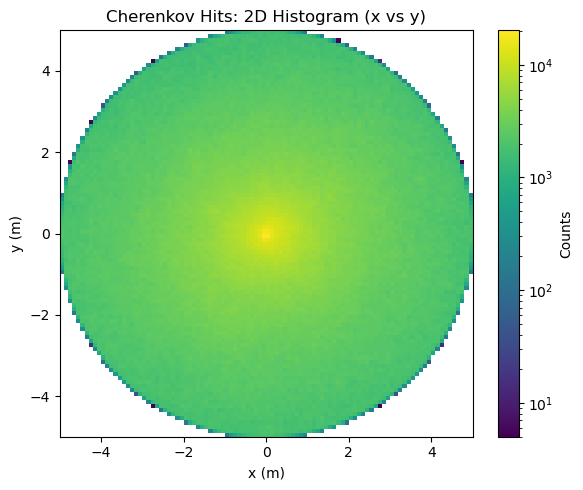

(b'EVTH', 1.0, 6.0, 100000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.553343, 4.712389, 0.0, [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.

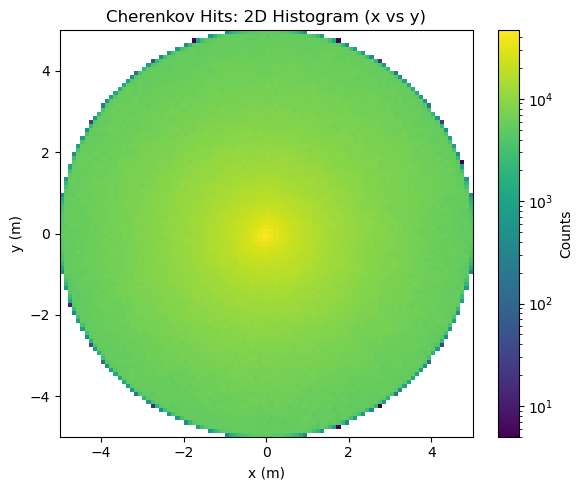

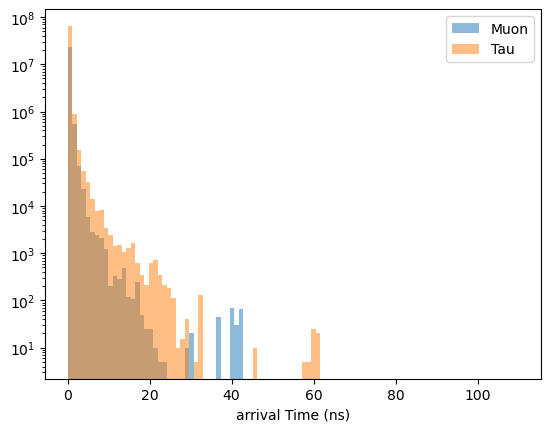

1228983.0 10553.137


In [2]:
input_file='/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Muon/CHASM/Tilt_91.560000/cherenkov_hits.dat'
input_file2='/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Tau/CHASM/Tilt_91.560000/cherenkov_hits3.dat'

#input_file='/uufs/chpc.utah.edu/common/home/u1520754/test_sim_chain/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/CHASM/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/cherenkov_hits.dat'
#input_file2='/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Muon/CHASM/Tilt_91.560000/cherenkov_hits.dat'

#input_file3='/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output_3/cherenkov_hits.dat'
X, Y, T, cos_X, cos_Y, wavelength, zem, Theta_z, Phi, Slant, Weight = read_cherenkov_hits(input_file)
X2, Y2, T2, cos_X2, cos_Y2, wavelength2, zem2, Theta_z2, Phi2, Slant2, Weight2 = read_cherenkov_hits(input_file2)
plt.hist((T-T.min()), bins=100, range=(0, 110), weights=Weight, label="Muon", alpha=0.5)
plt.hist((T2-T2.min()), bins=100, range=(0, 110), weights=Weight2, label="Tau", alpha=0.5)
plt.xlabel("arrival Time (ns)")
plt.yscale("log")
plt.legend()
plt.show()
print(T.min(), T2.min())

['allT;1', 'T1;1']
['eventNumber', 'primaryType', 'primaryEnergy', 'emergenceProbability', 'FirstIntHgt', 'FirstIntDpt', 'ShowerID', 'Xcore', 'Ycore', 'Xcos', 'Ycos', 'Xsource', 'Ysource', 'AzPrim', 'ZnPrim', 'AzTel', 'ZnTel', 'delay', 'photonX', 'photonY', 'time', 'wavelength', 'photonDcosX', 'photonDcosY']


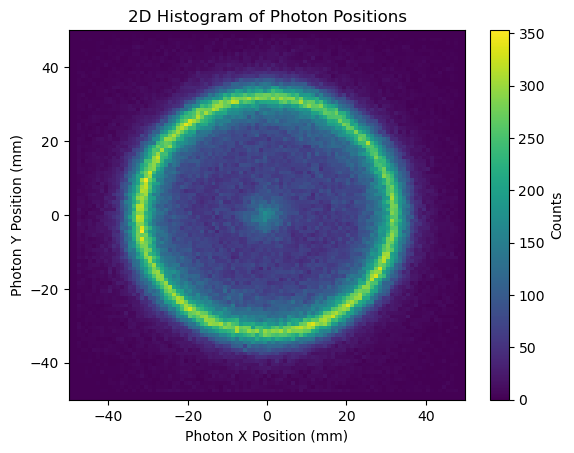

['allT;1', 'T1;1']
['eventNumber', 'primaryType', 'primaryEnergy', 'emergenceProbability', 'FirstIntHgt', 'FirstIntDpt', 'ShowerID', 'Xcore', 'Ycore', 'Xcos', 'Ycos', 'Xsource', 'Ysource', 'AzPrim', 'ZnPrim', 'AzTel', 'ZnTel', 'delay', 'photonX', 'photonY', 'time', 'wavelength', 'photonDcosX', 'photonDcosY']


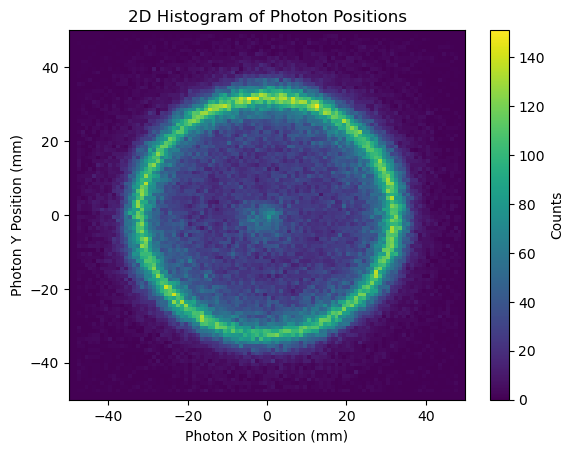

223231.78 1441661.6


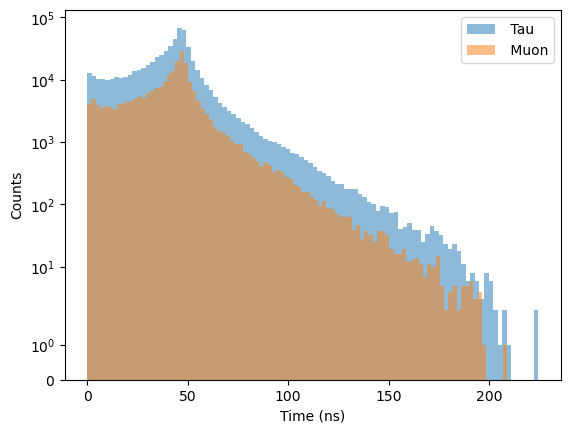

In [3]:
file ="/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Tau/GROPT/Tilt_91.560000/cherenkov_hits3.root"
file2="/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Muon/GROPT/Tilt_91.560000/cherenkov_hits.root"

#file = "/uufs/chpc.utah.edu/common/home/u1520754/test_sim_chain/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/GROPT/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/cherenkov_hits.root"
#file2= "/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Shower_2/GROPT/Tilt_91.560000/cherenkov_hits.root"
cosx, cosy, photonX_np, photonY_np, T = plot_GROPT(file)
cosx2, cosy2, photonX_np2, photonY_np2, T2 = plot_GROPT(file2)
print(T.min(), T2.min())
plt.hist((T-T.min()),bins=100, alpha=0.5, label=' Tau')
plt.hist((T2-T2.min()),bins=100, alpha=0.5, label=' Muon')
plt.yscale('symlog')
#plt.xscale('symlog')
plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.legend()
plt.show()

['TriggerArrayConfiguration;1', 'Events;1', 'Events/tSimulatedEvents;1', 'Events/T0;1', 'Pedestals;1', 'Pedestals/tSimulatedPedestals;1']
['vGroupsInTriggerCluster', 'vTimeOverThreshold', 'vSumTimeInPixel', 'vPEInPixel', 'vQDCValue', 'iPhotonsInFocalPlane', 'fAzTel', 'fZnTel', 'vHiLoGainBit', 'vFADCTraces0', 'vFADCTraces1', 'vFADCTraces2', 'vFADCTraces3', 'vFADCTraces4', 'vFADCTraces5', 'vFADCTraces6', 'vFADCTraces7', 'vFADCTraces8', 'vFADCTraces9', 'vFADCTraces10', 'vFADCTraces11', 'vFADCTraces12', 'vFADCTraces13', 'vFADCTraces14', 'vFADCTraces15', 'vFADCTraces16', 'vFADCTraces17', 'vFADCTraces18', 'vFADCTraces19', 'vFADCTraces20', 'vFADCTraces21', 'vFADCTraces22', 'vFADCTraces23', 'vFADCTraces24', 'vFADCTraces25', 'vFADCTraces26', 'vFADCTraces27', 'vFADCTraces28', 'vFADCTraces29', 'vFADCTraces30', 'vFADCTraces31', 'vFADCTraces32', 'vFADCTraces33', 'vFADCTraces34', 'vFADCTraces35', 'vFADCTraces36', 'vFADCTraces37', 'vFADCTraces38', 'vFADCTraces39', 'vFADCTraces40', 'vFADCTraces41', 'v

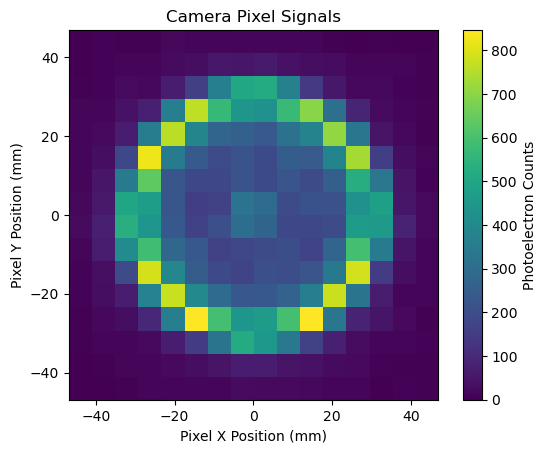

['TriggerArrayConfiguration;1', 'Events;1', 'Events/tSimulatedEvents;1', 'Events/T0;1', 'Pedestals;1', 'Pedestals/tSimulatedPedestals;1']
['vGroupsInTriggerCluster', 'vTimeOverThreshold', 'vSumTimeInPixel', 'vPEInPixel', 'vQDCValue', 'iPhotonsInFocalPlane', 'fAzTel', 'fZnTel', 'vHiLoGainBit', 'vFADCTraces0', 'vFADCTraces1', 'vFADCTraces2', 'vFADCTraces3', 'vFADCTraces4', 'vFADCTraces5', 'vFADCTraces6', 'vFADCTraces7', 'vFADCTraces8', 'vFADCTraces9', 'vFADCTraces10', 'vFADCTraces11', 'vFADCTraces12', 'vFADCTraces13', 'vFADCTraces14', 'vFADCTraces15', 'vFADCTraces16', 'vFADCTraces17', 'vFADCTraces18', 'vFADCTraces19', 'vFADCTraces20', 'vFADCTraces21', 'vFADCTraces22', 'vFADCTraces23', 'vFADCTraces24', 'vFADCTraces25', 'vFADCTraces26', 'vFADCTraces27', 'vFADCTraces28', 'vFADCTraces29', 'vFADCTraces30', 'vFADCTraces31', 'vFADCTraces32', 'vFADCTraces33', 'vFADCTraces34', 'vFADCTraces35', 'vFADCTraces36', 'vFADCTraces37', 'vFADCTraces38', 'vFADCTraces39', 'vFADCTraces40', 'vFADCTraces41', 'v

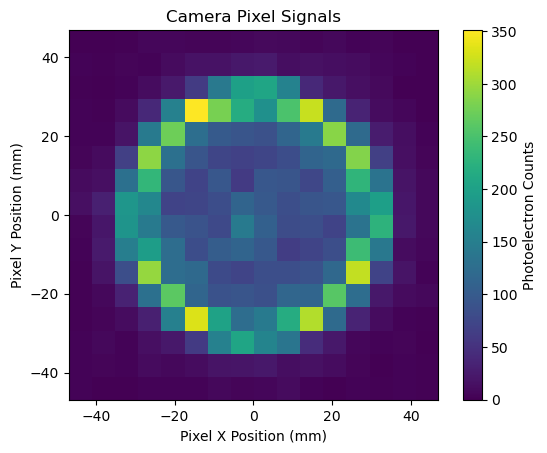

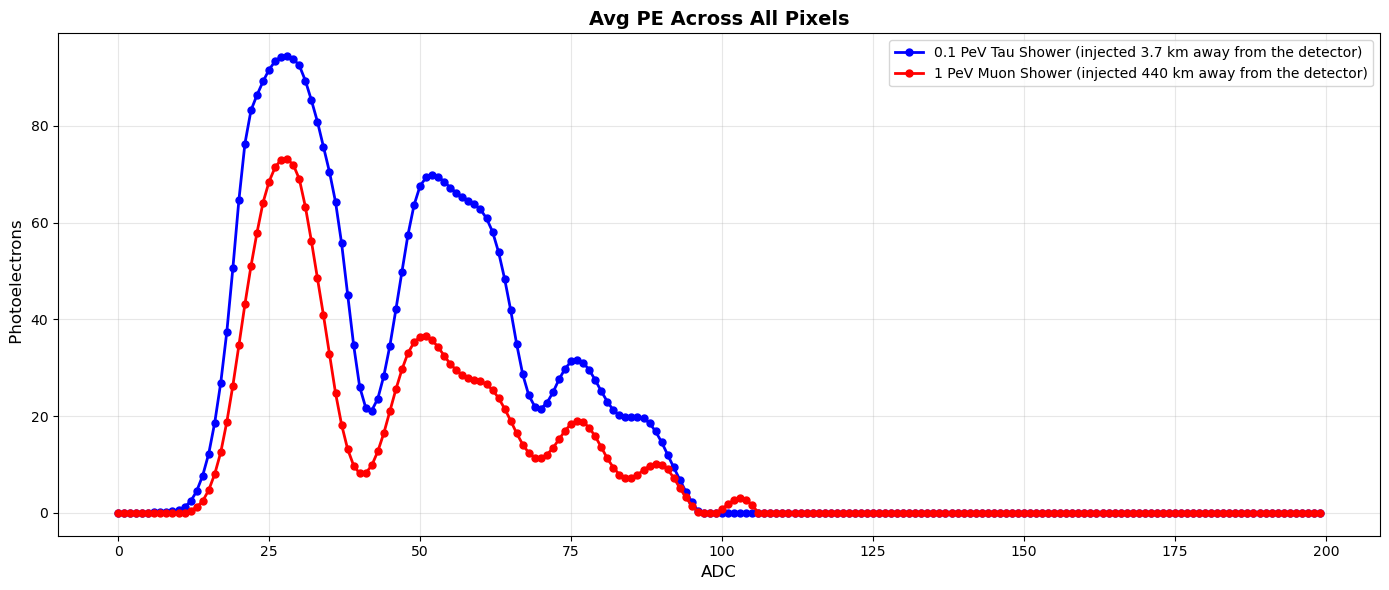

In [17]:
file = "/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Tau/CARE/Tilt_91.560000/cherenkov_hits3.root"
file2="/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Muon/CARE/Tilt_91.560000/cherenkov_hits.root"

#file = "/uufs/chpc.utah.edu/common/home/u1520754/test_sim_chain/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/CARE/Tilt_pdg13_E1e5_zen89_az270_h3000_r5_s42/cherenkov_hits.root"
#file2= "/uufs/chpc.utah.edu/common/home/u1520754/Detector_Sims/Test_Shower_2/CARE/Tilt_91.560000/cherenkov_hits.root"

camera_matrix, time_ns, total_pe, max_pe, arrays, pixel_config, min_x, max_x, min_y, max_y, pixel_pitch = plot_CARE(file)
camera_matrix2, time_ns2, total_pe2, max_pe2, arrays2, pixel_config2, min_x2, max_x2, min_y2, max_y2, pixel_pitch2 = plot_CARE(file2)
plt.figure(figsize=(14, 6))
ADC = np.arange(len(total_pe))
plt.plot(ADC, total_pe/256, marker='o', markersize=5, linewidth=2, color='blue', label='0.1 PeV Tau Shower (injected 3.7 km away from the detector)')
plt.plot(ADC, total_pe2/256, marker='o', markersize=5, linewidth=2, color='red', label='1 PeV Muon Shower (injected 440 km away from the detector)')
plt.xlabel('ADC', fontsize=12)
plt.ylabel(' Photoelectrons', fontsize=12)
plt.title('Avg PE Across All Pixels', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
#animation
import plotly.graph_objects as go

# Parameters
dc_to_pe = 24.1
baseline_dc = 500  # Fixed baseline from config

# Load all FADC traces for 256 pixels
print("Loading all 256 FADC traces...")
all_traces_pe = {}
for pix_id in range(256):
    trace_name = f"vFADCTraces{pix_id}"
    try:
        trace_dc = arrays[trace_name][0]
        # Convert to PE with fixed baseline
        trace_pe = np.clip((trace_dc - baseline_dc) / dc_to_pe, 0, None)
        all_traces_pe[pix_id] = trace_pe
    except KeyError:
        print(f"Warning: {trace_name} not found")

print(f"Successfully loaded {len(all_traces_pe)}/256 traces")

# Get time information (trigger at 170 ns)
n_samples = len(list(all_traces_pe.values())[0])
time_ns = np.arange(n_samples) * 10 - 170  # Relative to trigger

# Calculate max PE across all traces and time steps
max_pe_global = max([np.max(trace) for trace in all_traces_pe.values()])
min_pe_set = 1  # You can change this to set a minimum color scale value

print(f"Max PE across all pixels and time steps: {max_pe_global:.2f}")
print(f"Color scale: {min_pe_set} to {max_pe_global:.2f} PE")

print(f"Creating {n_samples} frames for animation...")

# Create frames for each time step
frames = []
for time_step in range(n_samples):
    # Create 16x16 grid for this time step
    pixel_grid = np.zeros((16, 16))
    
    # Map pixel values to grid positions
    for pix_id in range(256):
        if pix_id in all_traces_pe:
            # Get pixel location
            x_pos, y_pos = pixel_config[pix_id][1], pixel_config[pix_id][2]
            col = int((x_pos - min_x) / pixel_pitch)
            row = int((y_pos - min_y) / pixel_pitch)
            
            # Get PE value at this time step
            pixel_grid[row, col] = all_traces_pe[pix_id][time_step]
    
    # Create frame with fixed color scale
    frame = go.Frame(
        data=[go.Heatmap(z=pixel_grid, colorscale='Viridis', 
                         zmin=min_pe_set, zmax=max_pe_global,
                         colorbar=dict(title="PE"))],
        name=f"{time_ns[time_step]:.0f}"
    )
    frames.append(frame)

# Create initial frame data
initial_grid = np.zeros((16, 16))
for pix_id in range(256):
    if pix_id in all_traces_pe:
        x_pos, y_pos = pixel_config[pix_id][1], pixel_config[pix_id][2]
        col = int((x_pos - min_x) / pixel_pitch)
        row = int((y_pos - min_y) / pixel_pitch)
        initial_grid[row, col] = all_traces_pe[pix_id][0]

# Create figure
fig = go.Figure(
    data=[go.Heatmap(z=initial_grid, colorscale='Viridis', 
                     zmin=min_pe_set, zmax=max_pe_global,
                     colorbar=dict(title="PE"))],
    frames=frames
)

# Create slider steps
slider_steps = []
for i in range(0, len(frames), max(1, len(frames) // 200)):  # Limit to ~200 slider points
    slider_steps.append(
        dict(
            args=[
                [frames[i].name],
                dict(
                    frame=dict(duration=0, redraw=True),
                    mode="immediate",
                    transition=dict(duration=0)
                )
            ],
            label=f"{time_ns[i]:.0f} ns",
            method="animate"
        )
    )

# Update layout with slider and controls
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[
            dict(label="▶ Play",
                 method="animate",
                 args=[None, dict(frame=dict(duration=50, redraw=True),
                                 fromcurrent=True)]),
            dict(label="⏸ Pause",
                 method="animate",
                 args=[[None], dict(frame=dict(duration=0, redraw=False),
                                   mode="immediate",
                                   transition=dict(duration=0))])
        ],
        x=0.1, xanchor="left", y=1.15, yanchor="top"
    )],
    sliders=[dict(
        active=0,
        yanchor="top",
        y=-0.1,
        xanchor="left",
        currentvalue=dict(
            prefix="Time: ",
            suffix=" ns (relative to trigger)",
            visible=True,
            xanchor="center",
            font=dict(size=14)
        ),
        transition=dict(duration=0),
        pad=dict(b=10, t=50),
        len=0.9,
        x=0.05,
        steps=slider_steps
    )],
    title=dict(
        text=f"FADC Pixel Grid Animation (16×16 Pixels) - Color: {min_pe_set} to {max_pe_global:.1f} PE",
        font=dict(size=14)
    ),
    xaxis_title="Pixel Column Index",
    yaxis_title="Pixel Row Index",
    height=750,
    width=750,
    hovermode="closest"
)

print(f"\nAnimation settings:")
print(f"  • Baseline: {baseline_dc} DAC")
print(f"  • Conversion: {dc_to_pe} DAC/PE")
print(f"  • Color scale: {min_pe_set} to {max_pe_global:.2f} PE (fixed)")
print(f"  • Time: -170 ns (before trigger) to +1830 ns (after trigger)")
print("Displaying interactive Plotly figure...")
fig.show()


=== Integrated PE Analysis (Threshold: 20.0 PE) ===
Total integrated PE (above 20.0 PE threshold): 880311.78
Max integrated PE per pixel: 8739.96
Number of pixels with PE > 20.0: 199


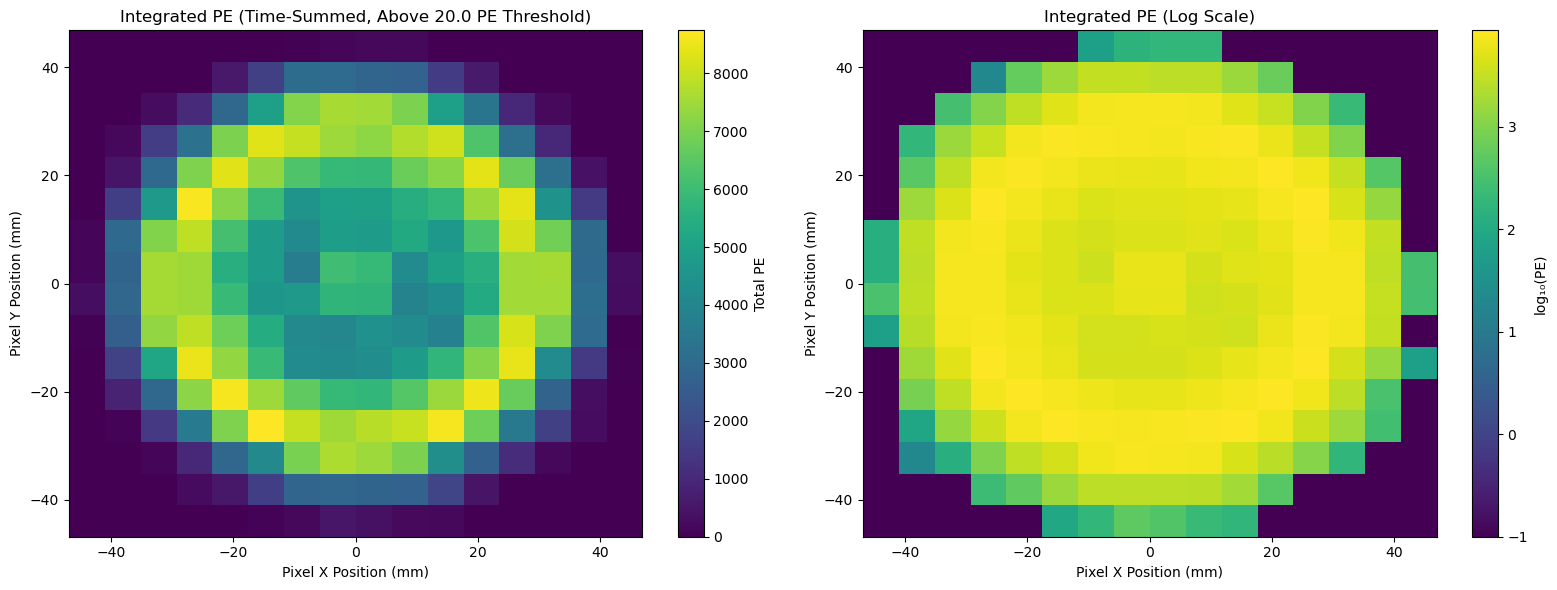


Top 10 Pixels by Integrated PE:
  1. Pixel 23 (-15.6, -28.1 mm): 8739.96 PE
  2. Pixel 142 (-28.1, 15.6 mm): 8654.36 PE
  3. Pixel 43 (15.6, -28.1 mm): 8634.32 PE
  4. Pixel 80 (-21.9, -21.9 mm): 8616.02 PE
  5. Pixel 108 (21.9, -21.9 mm): 8501.04 PE
  6. Pixel 77 (-28.1, -15.6 mm): 8495.89 PE
  7. Pixel 113 (28.1, -15.6 mm): 8440.25 PE
  8. Pixel 175 (21.9, 21.9 mm): 8388.30 PE
  9. Pixel 178 (28.1, 15.6 mm): 8367.05 PE
  10. Pixel 147 (-21.9, 21.9 mm): 8348.84 PE


In [6]:
# Integrated PE Plot - Sum over time for pixels above threshold
import matplotlib.pyplot as plt

# USER SETTING: Minimum PE threshold
pe_threshold = 20.0  # Only count PE values above this threshold

print(f"=== Integrated PE Analysis (Threshold: {pe_threshold} PE) ===")

# Sum PE over all time for each pixel, only counting values above threshold
integrated_pe_grid = np.zeros((16, 16))

for pix_id in range(256):
    if pix_id in all_traces_pe:
        x_pos, y_pos = pixel_config[pix_id][1], pixel_config[pix_id][2]
        col = int((x_pos - min_x) / pixel_pitch)
        row = int((y_pos - min_y) / pixel_pitch)
        
        # Get trace for this pixel
        trace = all_traces_pe[pix_id]
        
        # Sum only values above threshold
        above_threshold = trace[trace > pe_threshold]
        integrated_pe_grid[row, col] = np.sum(above_threshold)

# Statistics
total_integrated_pe = np.sum(integrated_pe_grid)
max_integrated_pe = np.max(integrated_pe_grid)
pixels_above_threshold = np.sum(integrated_pe_grid > 0)

print(f"Total integrated PE (above {pe_threshold} PE threshold): {total_integrated_pe:.2f}")
print(f"Max integrated PE per pixel: {max_integrated_pe:.2f}")
print(f"Number of pixels with PE > {pe_threshold}: {pixels_above_threshold}")

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Integrated PE heatmap
im1 = ax1.imshow(np.flip(integrated_pe_grid, axis=0), cmap='viridis', 
                 extent=(min_x, max_x, min_y, max_y), aspect='auto')
ax1.set_title(f'Integrated PE (Time-Summed, Above {pe_threshold} PE Threshold)')
ax1.set_xlabel('Pixel X Position (mm)')
ax1.set_ylabel('Pixel Y Position (mm)')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Total PE')

# Right plot: Same but with logarithmic scale
integrated_pe_grid_log = np.clip(integrated_pe_grid, 0.1, None)  # Avoid log(0)
im2 = ax2.imshow(np.flip(np.log10(integrated_pe_grid_log), axis=0), cmap='viridis',
                 extent=(min_x, max_x, min_y, max_y), aspect='auto')
ax2.set_title(f'Integrated PE (Log Scale)')
ax2.set_xlabel('Pixel X Position (mm)')
ax2.set_ylabel('Pixel Y Position (mm)')
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('log₁₀(PE)')

plt.tight_layout()
plt.show()

# Show top 10 pixels by integrated PE
print("\nTop 10 Pixels by Integrated PE:")
pixel_pe_list = []
for pix_id in range(256):
    if pix_id in all_traces_pe:
        x_pos, y_pos = pixel_config[pix_id][1], pixel_config[pix_id][2]
        col = int((x_pos - min_x) / pixel_pitch)
        row = int((y_pos - min_y) / pixel_pitch)
        integrated = integrated_pe_grid[row, col]
        if integrated > 0:
            pixel_pe_list.append((pix_id, integrated, x_pos, y_pos))

pixel_pe_list.sort(key=lambda x: x[1], reverse=True)
for i, (pix_id, pe_sum, x, y) in enumerate(pixel_pe_list[:10], 1):
    print(f"  {i}. Pixel {pix_id} ({x:.1f}, {y:.1f} mm): {pe_sum:.2f} PE")
